In [ ]:
# Kirjastot

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
import re

In [ ]:
# Datan lataaminen ja tarkastaminen
df = pd.read_csv('muokattu_twitter_dataset.csv')

df.head()

In [ ]:
# Valitaan tekstidata (Comments-sarake)
comments = df['Comment']

# Muunnetaan tekstidata numeeriseksi TF-IDF-vektorisoinnilla
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(comments)

In [ ]:
# Määritetään klusterien määrä (esimerkiksi 3: positiivinen, neutraali, negatiivinen)
k = 3

# K-means-algoritmin soveltaminen
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Lisätään klusteritieto dataan
df['Cluster'] = kmeans.labels_

# Näytetään muutamia rivejä klusteritiedolla
df[['Comment', 'Cluster']].head()



In [ ]:
# Tarkastellaan, kuinka monta viestiä kuuluu kuhunkin klusteriin
print(df.groupby('Cluster').size())

# Katsotaan esimerkkiviestejä jokaisesta klusterista
for cluster in range(k):
    print(f"\nCluster {cluster}:")
    print(df[df['Cluster'] == cluster]['Comment'].head(5).tolist())


In [ ]:
# Klustereiden tulkinta esimerkkiviestien perusteella
cluster_names = {
    0: "Negatiivinen",
    1: "Neutraali",
    2: "Positiivinen"
}

# Lisätään klusterin nimi dataan
df['Cluster_Label'] = df['Cluster'].map(cluster_names)

# Näytetään data klusterinimen kanssa
df[['Comment', 'Cluster', 'Cluster_Label']].head()


In [ ]:
# Visualisoidaan klusterien jakauma
cluster_counts = df['Cluster_Label'].value_counts()

plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title("Viestejä klustereittain")
plt.xlabel("Klusteri")
plt.ylabel("Viestimäärä")
plt.xticks(rotation=0)
plt.show()


2 käyttötapaus Viestien tulkinta

In [109]:
# Lasketaan tekstin ominaisuuksia jokaiselle viestille
df['Length'] = df['Comment'].apply(len)  # Merkkien määrä
df['Word_Count'] = df['Comment'].apply(lambda x: len(x.split()))  # Sanojen määrä
df['Avg_Word_Length'] = df['Length'] / df['Word_Count']  # Keskimääräinen sanan pituus
df['Exclamation_Count'] = df['Comment'].str.count(r'!')  # Huutomerkkejä
df['Dot_Count'] = df['Comment'].str.count(r'\.')  # Pisteitä

# Lasketaan toistuvat sanat
from collections import Counter
def word_repetition(comment):
    words = comment.lower().split()
    word_counts = Counter(words)
    return sum(count - 1 for count in word_counts.values() if count > 1)

df['Word_Repetition'] = df['Comment'].apply(word_repetition)

# Lasketaan lauseiden määrä (pisteet, huutomerkki, kysymysmerkki)
def sentence_count(comment):
    return len(re.findall(r'[.!?]', comment))

df['Sentence_Count'] = df['Comment'].apply(sentence_count)

# Lasketaan lauserakenteiden toistuvuus
def sentence_repetition(comment):
    sentences = [s.strip() for s in re.split(r'[.!?]', comment.lower()) if s.strip()]
    sentence_counts = Counter(sentences)
    return sum(count - 1 for count in sentence_counts.values() if count > 1)

df['Sentence_Repetition'] = df['Comment'].apply(sentence_repetition)

# Poistetaan sekaryhmä (klusteri 2)
df = df[df['Cluster_Bot'] != 2]

# Näytetään muutama rivi datasta uusilla ominaisuuksilla
df[['Comment', 'Length', 'Word_Count', 'Avg_Word_Length', 'Exclamation_Count', 'Dot_Count', 'Word_Repetition', 'Sentence_Count', 'Sentence_Repetition']].head()



,Comment,Length,Word_Count,Avg_Word_Length,Exclamation_Count,Dot_Count,Word_Repetition,Sentence_Count,Sentence_Repetition
2,my whole body feels itchy and like its on fire,47,10,4.700000,0,0,0,0,0
4,@Kwesidei not the whole crew,29,5,5.800000,0,0,0,0,0
5,Need a hug,11,3,3.666667,0,0,0,0,0
7,@Tatiana_K nope they didn't have it,36,6,6.000000,0,0,0,0,0
8,@twittera que me muera ?,25,5,5.000000,0,0,0,1,0


In [110]:
# Poistetaan sekaryhmä (klusteri 2) ennen klusterointia
df = df[df['Cluster_Bot'] != 2]

# Ominaisuudet k-means-klusterointiin
features = ['Length', 'Word_Count', 'Avg_Word_Length', 'Exclamation_Count', 'Dot_Count', 'Word_Repetition', 'Sentence_Count', 'Sentence_Repetition']

# Normaaliarvoistus (tärkeää k-meansille)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# K-means-algoritmi (aluksi testataan 3 klusteria, mutta voidaan optimoida)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster_Bot'] = kmeans.fit_predict(X_scaled)

# Klusterien jakauma
print(df['Cluster_Bot'].value_counts())


Cluster_Bot
0    152
1     93
2     47
Name: count, dtype: int64


In [111]:
# Esimerkkiviestit klustereista
for cluster in range(2):  # Kolme klusteria
    print(f"\nCluster {cluster} (Esimerkkiviestit):")
    print(df[df['Cluster_Bot'] == cluster]['Comment'].head(5).tolist())



Cluster 0 (Esimerkkiviestit):
['my whole body feels itchy and like its on fire ', '@Kwesidei not the whole crew ', 'Need a hug ', "@Tatiana_K nope they didn't have it ", '@twittera que me muera ? ']

Cluster 1 (Esimerkkiviestit):
['@octolinz16 It it counts, idk why I did either. you never talk to me anymore ', "Hollis' death scene will hurt me severely to watch on film  wry is directors cut not out now?", '@LettyA ahh ive always wanted to see rent  love the soundtrack!!', '@FakerPattyPattz Oh dear. Were you drinking out of the forgotten table drinks? ', "@alydesigns i was out most of the day so didn't get much done "]


In [112]:
# Klusterien tulkinta
cluster_names_bot = {
    0: "Ihmisten viestit",
    1: "Bottiviestit"
}

# Lisätään klusterinimi dataan
df['Cluster_Bot_Label'] = df['Cluster_Bot'].map(cluster_names_bot)

# Näytetään data klusterinimen kanssa
df[['Comment', 'Cluster_Bot', 'Cluster_Bot_Label']].head()

# Klusterikohtainen analyysi ja tyypillisten piirteiden tarkastelu
for cluster in range(2):
    print(f"\nAnalyysi - Cluster {cluster} ({cluster_names_bot[cluster]}):")
    cluster_data = df[df['Cluster_Bot'] == cluster]
    
    # Klusterin koko
    print(f"Klusterin koko: {cluster_data.shape[0]} viestiä")
    
    # Keskiarvot klusterin ominaisuuksista
    avg_features = cluster_data[['Length', 'Word_Count', 'Avg_Word_Length', 'Exclamation_Count', 'Dot_Count']].mean()
    print(f"Keskiarvot ominaisuuksista: \n{avg_features}")
    
    # Esimerkkiviestit
    print(f"\nEsimerkkiviestit ({cluster_names_bot[cluster]}):")
    example_comments = cluster_data['Comment'].head(5).tolist()
    for idx, comment in enumerate(example_comments):
        print(f"Esimerkki {idx+1}: {comment}")



Analyysi - Cluster 0 (Ihmisten viestit):
Klusterin koko: 152 viestiä
Keskiarvot ominaisuuksista: 
Length               35.967105
Word_Count            6.434211
Avg_Word_Length       5.847381
Exclamation_Count     0.203947
Dot_Count             0.302632
dtype: float64

Esimerkkiviestit (Ihmisten viestit):
Esimerkki 1: my whole body feels itchy and like its on fire 
Esimerkki 2: @Kwesidei not the whole crew 
Esimerkki 3: Need a hug 
Esimerkki 4: @Tatiana_K nope they didn't have it 
Esimerkki 5: @twittera que me muera ? 

Analyysi - Cluster 1 (Bottiviestit):
Klusterin koko: 93 viestiä
Keskiarvot ominaisuuksista: 
Length               74.698925
Word_Count           13.494624
Avg_Word_Length       5.552802
Exclamation_Count     0.376344
Dot_Count             0.516129
dtype: float64

Esimerkkiviestit (Bottiviestit):
Esimerkki 1: @octolinz16 It it counts, idk why I did either. you never talk to me anymore 
Esimerkki 2: Hollis' death scene will hurt me severely to watch on film  wry is direct

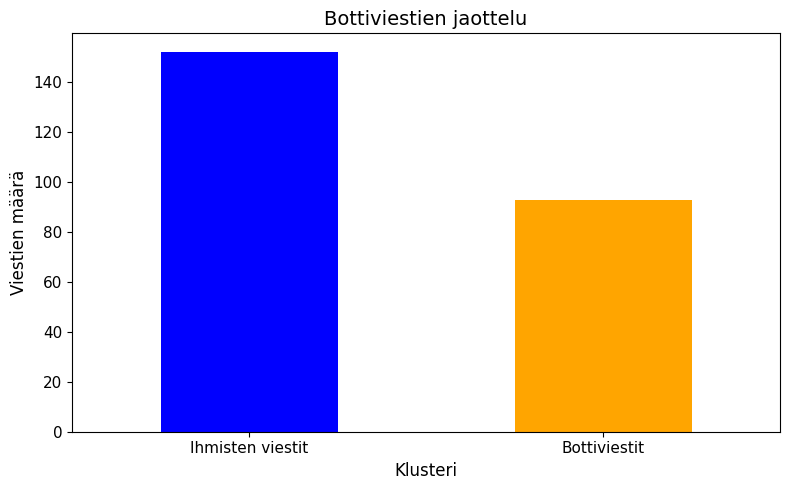

In [113]:
# Klusterien jakauman visualisointi
bot_counts = df['Cluster_Bot_Label'].value_counts()

# Visualisoidaan klusterien jakauma
plt.figure(figsize=(8, 5))

# Värit vain kahdelle klusterille
bot_counts.plot(kind='bar', color=['blue', 'orange'])  # Poistettu sekaryhmä

plt.title("Bottiviestien jaottelu", fontsize=14)
plt.xlabel("Klusteri", fontsize=12)
plt.ylabel("Viestien määrä", fontsize=12)

# Akselin nimet ja värit
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

# Parannetaan ulkoasua
plt.tight_layout()
plt.show()


